# Topic Modelling on Program Source Code
---
By Kishalay Banerjee, Dan Jones and Sam Harding

In [1]:
import warnings
warnings.filterwarnings('ignore')  # 0y

In [2]:
import pandas
import pickle
import math
import numpy
import seaborn
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

/home/dan/.guix-profile/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/dan/.guix-profile/lib/python3.7/site-packages/funcy/colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
/home/dan/.guix-profile/lib/python3.7/site-packages/funcy/seqs.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, deque, Sequence
/home/dan/.guix-profile/lib/python3.7/site-packages/funcy/flow.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of f

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from urllib.request import urlretrieve

In [4]:
numpy.random.seed(0xC0FFEE) 

## Preparation

There are a number of files which are too large to store on GitHub. These are hosted on our server, and can be downloaded by running the following cell:

In [5]:
files = [
    'full_lda_model.pickle',
    'full_tf.pickle',
    'full_tf_vectorizer.pickle',
    'full-dataset.csv.gz',
]

base_url = 'https://daniel.wilshirejones.com/private-uUX6IzfsRYLNiti4ZFmgv6U3dFInnq37r5YSQs46iejeB96q0MAy9Ko7hkgo/'
destination_directory = '../data/'

for file in files:
    url = base_url + file
    destination = destination_directory + file
    print("Downloading '{}'' to location '{}'".format(url, destination))
    urlretrieve(url, destination)

## Generating the Dataset

TODO: Import dataset.py and explain how it's used + what it does.

TODO: Add Sam's scrub function in here?

In [5]:
minimal_dataset = pandas.read_csv("../data/dataset.csv.gz", header=None, names=['repo', 'language', 'documents'])
minimal_dataset.head()

,repo,language,documents
0,28457823,javascript,"b""module.exports = {\n plugins: [\n requir..."
1,28457823,javascript,"b""// The path where to mount the REST API app\..."
2,28457823,javascript,"b""import { Observable } from 'rx';\nimport deb..."
3,28457823,javascript,"b""import { Observable } from 'rx';\n// import ..."
4,28457823,javascript,"b""import { Observable } from 'rx';\n\nmodule.e..."


In [6]:
full_dataset = pandas.read_csv("../data/full-dataset.csv.gz", header=None, names=['repo', 'language',  'topics', 'documents'])

# Remove Github 'topics' since we don't use them in this analysis
full_dataset = full_dataset.drop(columns='topics')

full_dataset.head()

,repo,language,documents
0,28457823,javascript,"b""module.exports = {\n plugins: [\n requir..."
1,28457823,javascript,"b""// The path where to mount the REST API app\..."
2,28457823,javascript,"b""import { Observable } from 'rx';\nimport deb..."
3,28457823,javascript,"b""import { Observable } from 'rx';\n// import ..."
4,28457823,javascript,"b""import { Observable } from 'rx';\n\nmodule.e..."


In [7]:
test_dataset = pandas.read_csv("../data/test-dataset.csv.gz", header=None, names=['repo', 'language', 'topics', 'documents'])

# Remove Github 'topics' since we don't use them in this analysis
test_dataset = test_dataset.drop(columns='topics')

test_dataset.head()

,repo,language,documents
0,69798748,javascript,"b""const glob = require('glob')\nconst markdown..."
1,128624453,javascript,"b""module.exports = {\n extends: ['@commitlint..."
2,128624453,javascript,"b""module.exports = {\n extends: ['standard', ..."
3,128624453,javascript,"b""const cp = require('child_process')\nconst g..."
4,128624453,javascript,"b""module.exports = {\n verbose: true,\n tran..."


To evaluate the mixture model, we must label each repository with it's percentage of each programming language:

In [8]:
def calculate_language_percentages(group):
    total_python_length = 0
    total_r_length = 0
    total_javascript_length = 0
    
    for index, repo, language, document in group.itertuples():
        if language == 'python':
            total_python_length += len(document)
            
        if language == 'javascript':
            total_javascript_length += len(document)
            
        if language == 'r':
            total_r_length += len(document)
            
    total_length = total_python_length + total_r_length + total_javascript_length
            
    return pandas.Series([
        total_python_length/total_length,
        total_r_length/total_length,
        total_javascript_length/total_length,
    ])

In [9]:
test_composition_actual = test_dataset.groupby(by='repo').apply(calculate_language_percentages)
test_composition_actual.columns = ['python', 'r', 'javascript']

Here are the programming language percentages for each of repository in our test dataset:

In [10]:
test_composition_actual

,python,r,javascript
repo,,,
596892,1.000000,0.000000,0.000000
1248263,0.652443,0.000000,0.347557
1790564,0.000000,0.000000,1.000000
4751958,0.360730,0.000000,0.639270
12465340,0.000000,0.995105,0.004895
13523710,0.000000,1.000000,0.000000
14267375,0.941701,0.000000,0.058299
14579179,0.000000,0.189083,0.810917
16146440,0.000000,0.253421,0.746579


In [11]:
def concat_texts(group):
    [repo_id] = group['repo'].unique()
    combined = ' '.join(group['documents'])
    return combined

In [12]:
combined_test_documents = test_dataset.groupby(by='repo').apply(concat_texts)

## Ideal Programming Language Distributions

We would expect the keywords of each programming language to be an important indicator of the program language. These will be used later to identify the programming langauge that each topic represents:


In [15]:
import keyword

python_keywords = keyword.kwlist
python_keywords

['False',
 'None',
 'True',
 'and',
 'as',
 'assert',
 'async',
 'await',
 'break',
 'class',
 'continue',
 'def',
 'del',
 'elif',
 'else',
 'except',
 'finally',
 'for',
 'from',
 'global',
 'if',
 'import',
 'in',
 'is',
 'lambda',
 'nonlocal',
 'not',
 'or',
 'pass',
 'raise',
 'return',
 'try',
 'while',
 'with',
 'yield']

R reserved words (sourced from the manual: https://stat.ethz.ch/R-manual/R-devel/library/base/html/Reserved.html)

In [16]:
r_keywords = [
    "if", 
    "else", 
    "repeat",
    "while",
    "function", 
    "for",
    "in",
    "next",
    "break",
    "TRUE",
    "FALSE",
    "NULL", 
    "Inf", 
    "NaN",
    "NA",
    "NA_integer_",
    "NA_real_",
    "NA_complex_",
    "NA_character_", 
]

Javascript keywords and reserved words (source: https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Lexical_grammar#Keywords)

In [17]:
javascript_keywords = [  # jaccard("ideal javascript topic", topic_i)
    "break",
    "case",
    "catch",
    "class",
    "const",
    "continue",
    "debugger",
    "default",
    "delete",
    "do",
    "else",
    "export",
    "extends",
    "finally",
    "for",
    "function",
    "if",
    "import",
    "in",
    "instanceof",
    "new",
    "return",
    "super",
    "switch",
    "this",
    "throw",
    "try",
    "typeof",
    "var",
    "void",
    "while",
    "with",
    "yield",
]

## Topic Modelling on Individual Source Files

Basically done, just need to copy it over. Maybe run on the bigger dataset?

TODO:
  - Copy work from documentation/daniel-jones.ipynb
  - Add visualisation with pyldavis

For our purposes, common words are important and rare words aren't. So we shouldn't use tf-idf as a metric, bag-of-words makes more sense. (TODO: Maybe: "Similarly, filter out words that don't occur very often").


In [13]:
documents = minimal_dataset['documents']

In [ ]:
tf_vectorizer = CountVectorizer(stop_words=None)
tf = tf_vectorizer.fit_transform(documents)

with open('../data/minimal_lda_tf.pickle', 'wb') as f:
    pickle.dump(tf, f)
    
with open('../data/minimal_lda_tf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tf_vectorizer, f)

We have four programming languages, try to use LDA to determine these four programming languages.

In [ ]:
number_of_languages = 4

lda = LatentDirichletAllocation(n_topics=number_of_languages,  n_jobs=1)
model = lda.fit(tf)

with open('../data/minimal_lda_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [14]:
with open('../data/minimal_lda_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/minimal_lda_tf.pickle', 'rb') as f:
    tf = pickle.load(f)
    
with open('../data/minimal_lda_tf_vectorizer.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

In [14]:
pyLDAvis.sklearn.prepare(model, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.170498  0.068422       1        1  53.661148
3      0.334580 -0.137167       2        1  17.800762
1     -0.215109 -0.203095       3        1  16.993209
2      0.051028  0.271840       4        1  11.544881, topic_info=       Category          Freq           Term         Total  loglift  logprob
term                                                                        
224987  Default  76787.000000           self  76787.000000  30.0000  30.0000
209790  Default  28422.000000          react  28422.000000  29.0000  29.0000
118970  Default  35518.000000           from  35518.000000  28.0000  28.0000
257199  Default  93096.000000           this  93096.000000  27.0000  27.0000
256596  Default  71532.000000            the  71532.000000  26.0000  26.0000
138187  Default  75532.000000             if  75532.000000  25.0000  25.0000
93741   Default  26333.000000        default  26333.000000  24.0000  24.0000
93727   Default  19823.000000            def  19823.000000  23.0000  23.0000
119762  Default  78705.000000       function  78705.000000  22.0000  22.0000
139197  Default  26520.000000         import  26520.000000  21.0000  21.0000
180274  Default  18618.000000        nimport  18618.000000  20.0000  20.0000
178605  Default  13422.000000        nexport  13422.000000  19.0000  19.0000
6203    Default  19257.000000             12  19257.000000  18.0000  18.0000
179191  Default  15713.000000          nfrom  15713.000000  17.0000  17.0000
88624   Default  12159.000000  createsvgicon  12159.000000  16.0000  16.0000
195902  Default  18062.000000           path  18062.000000  15.0000  15.0000
182715  Default  21713.000000           none  21713.000000  14.0000  14.0000
270897  Default  16822.000000           user  16822.000000  13.0000  13.0000
10108   Default  14036.000000             16  14036.000000  12.0000  12.0000
216978  Default  74742.000000         return  74742.000000  11.0000  11.0000
139409  Default  34335.000000             in  34335.000000  10.0000  10.0000
273107  Default  50512.000000            var  50512.000000   9.0000   9.0000
58561   Default  16313.000000             as  16313.000000   8.0000   8.0000
118218  Default   8955.000000       fragment   8955.000000   7.0000   7.0000
4646    Default  16616.000000             10  16616.000000   6.0000   6.0000
281843  Default   7860.000000            xd0   7860.000000   5.0000   5.0000
16221   Default  10334.000000             24  10334.000000   4.0000   4.0000
80378   Default   8276.000000      classname   8276.000000   3.0000   3.0000
281885  Default   7548.000000            xe0   7548.000000   2.0000   2.0000
173909  Default  23687.000000           name  23687.000000   1.0000   1.0000
...         ...           ...            ...           ...      ...      ...
281761   Topic4   1464.391410            xbd   1487.025518   2.1436  -6.2404
281631   Topic4   1663.439660            xb4   1699.407348   2.1375  -6.1129
281809   Topic4   2187.518169            xc3   2248.312349   2.1315  -5.8390
209790   Topic4  26136.460497          react  28422.863801   2.0751  -3.3585
281786   Topic4   1213.602554            xbf   1241.477370   2.1362  -6.4282
80378    Topic4   7546.761037      classname   8276.007692   2.0667  -4.6007
281561   Topic4   1517.149330            xb0   1563.031406   2.1291  -6.2050
281345   Topic4   1061.601815            xa5   1081.515369   2.1403  -6.5620
205348   Topic4   4516.349076      proptypes   4899.945261   2.0774  -5.1141
280778   Topic4   2783.143067            x80   2961.846853   2.0967  -5.5982
281673   Topic4   2447.870929            xb8   2614.659009   2.0930  -5.7266
125631   Topic4   1890.410526        gettext   2012.120308   2.0965  -5.9850
118970   Topic4  25303.791250           from  35518.688459   1.8198  -3.3908
159703   Topic4   3531.937969             m0   4032.249447   2.0265  -5.3600
180274   Topic

Find the 35 most important words for this dataset, and use our ideal programming language topic to identify the language each topic represents:

In [19]:
def get_word_importance_per_topic(model, tf_vectorizer):
    feature_map = dict(enumerate(tf_vectorizer.get_feature_names()))
    
    word_importance_per_topic = []

    for topic_components in model.components_:
        word_importance = [
            (feature_map[feature_index], feature_importance) 
            for feature_index, feature_importance in enumerate(topic_components)
        ]
        word_importance = sorted(word_importance, key=lambda tup: tup[1], reverse=True)
        word_importance_per_topic.append(word_importance)
        
    return word_importance_per_topic

In [20]:
word_importance_per_topic = get_word_importance_per_topic(model, tf_vectorizer)

In [28]:
most_importance_topic_1_keywords = [word for word, importance in word_importance_per_topic[0][0:50]]
most_importance_topic_2_keywords = [word for word, importance in word_importance_per_topic[1][0:50]]
most_importance_topic_3_keywords = [word for word, importance in word_importance_per_topic[2][0:50]]
most_importance_topic_4_keywords = [word for word, importance in word_importance_per_topic[3][0:50]]

### Jaccard Index

From the papers above this seems to have been used relatively often for _linking machine-generated topics to human topics_ and so maybe this is a good application for it. Apparently explored here "https://link.springer.com/chapter/10.1007/978-3-642-19437-5_13" but I haven't read it.


In [29]:
def jaccard_index(a, b):
    a = set(a)
    b = set(b)
    
    num_shared = float(len(a & b))
    num_total = float(len(a | b))
    
    return num_shared/num_total

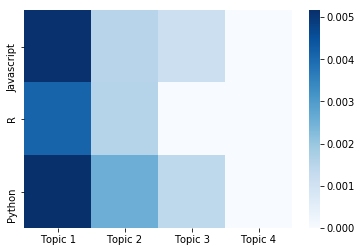

In [30]:
jaccard_indexes = pandas.DataFrame(
    numpy.array([
        [
            jaccard_index(javascript_keywords, most_importance_topic_1_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_2_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_3_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_4_keywords)/len(javascript_keywords)
        ],
        [
            jaccard_index(r_keywords, most_importance_topic_1_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_2_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_3_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_4_keywords)/len(r_keywords),
        ],
        [
            jaccard_index(python_keywords, most_importance_topic_1_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_2_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_3_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_4_keywords)/len(python_keywords),
        ],
    ]),
    columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'],
    index=['Javascript', 'R', 'Python']
)

hm = seaborn.heatmap(
    jaccard_indexes,
    cmap='Blues',
)

Looking at this heatmap we can see that "Topic 1" has a high overlap with all of the programming language keywords, whilst the others have little. This may tell us that the LDA model has grouped programming language keywords together, and has not been successfull in distinguishing them.

It is interesting to note that the most important words for "Topic 4" are all numbers, and it shows little similarity to our ideal programming langauge distributions.

In the next section we consider the impact of running this on a larger dataset, with the hope that this improve the models ability to distinguish our programming languages.

### Applying LDA model to a larger dataset

TODO: describe

In [ ]:
number_of_languages = 4
all_documents = full_dataset['documents']

full_tf_vectorizer = CountVectorizer(stop_words=None)
full_tf = full_tf_vectorizer.fit_transform(all_documents)
full_tf_feature_names = full_tf_vectorizer.get_feature_names()

full_lda = LatentDirichletAllocation(n_topics=number_of_languages,  n_jobs=1)
full_model = full_lda.fit(full_tf)

with open('../data/full_lda_model.pickle', 'wb') as f:
    pickle.dump(full_model, f)

with open('../data/full_tf.pickle', 'wb') as f:
    pickle.dump(full_tf, f)
    
with open('../data/full_tf_vectorizer.pickle', 'wb') as f:
    pickle.dump(full_tf_vectorizer, f)

In [15]:
with open('../data/full_lda_model.pickle', 'rb') as f:
    full_model = pickle.load(f)

with open('../data/full_tf.pickle', 'rb') as f:
    full_tf = pickle.load(f)
    
with open('../data/full_tf_vectorizer.pickle', 'rb') as f:
    full_tf_vectorizer = pickle.load(f)

Visualize our new model. Note that the following code cell requires more than 8 GB of RAM to run.

In [ ]:
pyLDAvis.sklearn.prepare(full_model, full_tf, full_tf_vectorizer)

Reference: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

## Topic Modelling on Programming Language Mixtures
Keypoint: topics are programming languages, file with mixture of programming languages, identify which is which.

Applicability to cyber-security: identifying malware embedded within normal programs (shellcode).

### Combining Source Files per Repository

Currently our data set consists of one data point per file containing:
  1. ID of the Github repository the file belongs to.
  2. Programming language it is written in (identified by file extension).
  3. File contents
  
In this section, we extend our analysis from working on documents with one language per file, to a system where there is a mixture of languages inside each document. To do this, we combine all the files in each repository into a single data point.

In [31]:
combined_documents = minimal_dataset.groupby(by='repo').apply(concat_texts)

In [32]:
combined_documents.head()

repo
19438      b"#' @include ggplot-global.R\n#' @include ggp...
26554      b'# The contents of this file are subject to t...
544208     b'import logging\nimport os\nimport platform a...
643909     b'#\' Environment variables to set when callin...
2594513    b'# S3 method to deal with chunks and inline t...
dtype: object

### LDA Model 

In [26]:
tf_vectorizer = CountVectorizer(stop_words=None)
tf_vectorizer.fit(combined_test_documents.append(combined_documents))

tf_train = tf_vectorizer.transform(combined_documents)
tf_test = tf_vectorizer.transform(combined_test_documents)

with open('../data/concatDocs_tf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tf_vectorizer, f)
    
with open('../data/concatDocs_tf_train.pickle', 'wb') as f:
    pickle.dump(tf_train, f)
    
with open('../data/concatDocs_tf_test.pickle', 'wb') as f:
    pickle.dump(tf_test, f)

In [27]:
number_of_languages = 4

lda = LatentDirichletAllocation(n_topics=number_of_languages,  n_jobs=1)
model = lda.fit(tf_train)

with open('../data/concatDocs_lda_model.pickle', 'wb') as f:
    pickle.dump(model, f)

/home/dan/.guix-profile/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [33]:
with open('../data/concatDocs_lda_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/concatDocs_tf_train.pickle', 'rb') as f:
    tf_train = pickle.load(f)
    
with open('../data/concatDocs_tf_vectorizer.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

with open('../data/concatDocs_tf_test.pickle', 'rb') as f:
    tf_test = pickle.load(f)

In [34]:
pyLDAvis.sklearn.prepare(model, tf_train, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.086398 -0.116452       1        1  37.813179
0     -0.294979  0.013923       2        1  24.391070
1      0.081823 -0.026082       3        1  20.049074
3      0.126758  0.128611       4        1  17.746676, topic_info=       Category          Freq           Term         Total  loglift  logprob
term                                                                        
292282  Default  72580.000000           self  72580.000000  30.0000  30.0000
9020    Default  24021.000000             12  24021.000000  29.0000  29.0000
272177  Default  35322.000000          react  35322.000000  28.0000  28.0000
113531  Default  14716.000000  createsvgicon  14716.000000  27.0000  27.0000
14064   Default  17744.000000             16  17744.000000  26.0000  26.0000
152146  Default  38825.000000           from  38825.000000  25.0000  25.0000
21337   Default  13331.000000             24  13331.000000  24.0000  24.0000
33748   Default  11513.000000             48  11513.000000  23.0000  23.0000
337054  Default  88252.000000           this  88252.000000  22.0000  22.0000
230415  Default  15229.000000        nexport  15229.000000  21.0000  21.0000
11483   Default  11562.000000             14  11562.000000  20.0000  20.0000
8131    Default  12851.000000             11  12851.000000  19.0000  19.0000
25875   Default  11830.000000             32  11830.000000  18.0000  18.0000
19830   Default   9994.000000             21   9994.000000  17.0000  17.0000
151322  Default  10823.000000       fragment  10823.000000  16.0000  16.0000
10608   Default  10975.000000             13  10975.000000  15.0000  15.0000
32379   Default   9527.000000             45   9527.000000  14.0000  14.0000
153179  Default  73186.000000       function  73186.000000  13.0000  13.0000
14863   Default   9604.000000             17   9604.000000  12.0000  12.0000
231304  Default  14798.000000          nfrom  14798.000000  11.0000  11.0000
6769    Default  18277.000000             10  18277.000000  10.0000  10.0000
76632   Default  18442.000000         assert  18442.000000   9.0000   9.0000
119984  Default  18653.000000            def  18653.000000   8.0000   8.0000
178063  Default  72633.000000             if  72633.000000   7.0000   7.0000
232874  Default  20848.000000        nimport  20848.000000   6.0000   6.0000
20337   Default   7873.000000             22   7873.000000   5.0000   5.0000
273353  Default   5367.000000          realm   5367.000000   4.0000   4.0000
13353   Default   9736.000000             15   9736.000000   3.0000   3.0000
22480   Default   7139.000000             26   7139.000000   2.0000   2.0000
120001  Default  26179.000000        default  26179.000000   1.0000   1.0000
...         ...           ...            ...           ...      ...      ...
214665   Topic4   6021.360834        message  11338.275645   1.0961  -5.2564
136216   Topic4   2269.860016          equal   3175.562886   1.3932  -6.2320
281958   Topic4   4886.122578         result   9355.692256   1.0794  -5.4654
124101   Topic4   2906.351220           dict   4606.657827   1.2684  -5.9849
215038   Topic4   1838.636551       messages   2452.324241   1.4410  -6.4427
177551   Topic4   7133.916724             id  16162.409786   0.9111  -5.0869
227376   Topic4   4437.436003           ndef   8628.785003   1.0639  -5.5617
236539   Topic4   8250.619553           none  21002.845103   0.7946  -4.9415
231304   Topic4   6422.092931          nfrom  14798.917305   0.8942  -5.1920
76632    Topic4   7267.963807         assert  18442.496301   0.7978  -5.0683
218648   Topic4   3734.759476         models   6922.545411   1.1119  -5.7341
248634   Topic4   2475.243189          order   4030.059844   1.2415  -6.1454
178063   Topic4  13673.749760             if  72633.584502   0.0590  -4.4363
179408   Topic4   7280.681883         import  26153.166794   0.4502  -5.0665
367087   Topic

In [18]:
word_importance_per_topic = get_word_importance_per_topic(model, tf_vectorizer)

In [51]:
most_importance_topic_1_keywords = [word for word, importance in word_importance_per_topic[0][0:35]]
most_importance_topic_2_keywords = [word for word, importance in word_importance_per_topic[1][0:35]]
most_importance_topic_3_keywords = [word for word, importance in word_importance_per_topic[2][0:35]]
most_importance_topic_4_keywords = [word for word, importance in word_importance_per_topic[3][0:35]]

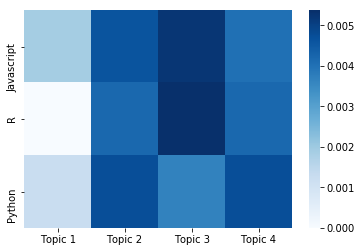

In [52]:
jaccard_indexes = pandas.DataFrame(
    numpy.array([
        [
            jaccard_index(javascript_keywords, most_importance_topic_1_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_2_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_3_keywords)/len(javascript_keywords),
            jaccard_index(javascript_keywords, most_importance_topic_4_keywords)/len(javascript_keywords)
        ],
        [
            jaccard_index(r_keywords, most_importance_topic_1_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_2_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_3_keywords)/len(r_keywords),
            jaccard_index(r_keywords, most_importance_topic_4_keywords)/len(r_keywords),
        ],
        [
            jaccard_index(python_keywords, most_importance_topic_1_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_2_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_3_keywords)/len(python_keywords),
            jaccard_index(python_keywords, most_importance_topic_4_keywords)/len(python_keywords),
        ],
    ]),
    columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'],
    index=['Javascript', 'R', 'Python']
)

hm = seaborn.heatmap(
    jaccard_indexes,
    cmap='Blues',
)

Examining the heatmap above shows tells us that:
  
  1. Topic 1 best reporesents Javascript
  2. Topic 2 best represesents Python
  3. Topic 3 best represents R
  4. Topic 4 best represents Python
  

However, it is worth noting that these topics are a mixture and does not differentiate between these programming languages very well. This is potentially caused by the similarity in the keywords of each language

In [35]:
mixture_topic_language_map = {
    1: 'javascript',
    2: 'python',
    3: 'r',
    4: 'python',
}

## Alternative Splitting Function

One potential problem we identified was with the method that sklearn uses to split up the program into "words". The base function searches the program for strings of two or more alphanumeric characters in a row, taking these as the words of a particular document. The issue here is that most code contains comments (which are heavy in alphanumeric characters that offer little to no help in detecting the programming language (or at least it is hard to detect the phrases that are helpful)), and also non-alphanumeric characters that might help to detect the language (for instance certain forms of brackets, colons, and other indicators). Therefore we set to design a new splitting function which would hopefully filter out non-useful information and leave us with a list of words that has more to say about the language being written.

In [ ]:
def trim(text):
    if type(text)==str:
        return text.lstrip().rstrip()
    elif type(text)==list:
        tram=[]
        for i in text:
            tram.append(i.lstrip().rstrip())
        return tram
    else:
        return "Not Correct Format"
def splat(text, splt):
    if type(text)==str:
        splot=str.split(text[2:-1], splt)
        return trim(splot)
    elif type(text)==list:
        splot=[]
        for i in text:
            for j in str.split(i,splt):
                splot.append(j)
        return trim(splot)
    else:
        return "Not Correct Format"
def scrub(string, inclComments=False):
    x=string
    x=splat(x,"\\n")
    if inclComments==False:
        x=[i for i in x if i[0:2]!="//"]
        x=[i for i in x if i[0:1]!="#"]
    x=splat(x,"(")
    x=splat(x,"[")
    x=splat(x,"{")
    x=splat(x," ")
    x=[i for i in x if i!=""]
    return x
def concatMe(a):
    return " ".join(a)

We then apply an almost identical method as before to run LDA on these new modified documents:

In [ ]:
combined_split_documents=combined_documents.apply(scrub).apply(concatMe)
combined_split_test_documents=combined_test_documents.apply(scrub).apply(concatMe)

In [ ]:
split_tf_vectorizer = CountVectorizer(stop_words=None, token_pattern="[^ ]*")
split_tf_vectorizer.fit(combined_split_test_documents.append(combined_split_documents))

split_tf_train = split_tf_vectorizer.transform(combined_split_documents)
split_tf_test = split_tf_vectorizer.transform(combined_split_test_documents)

with open('../data/concatDocs_split_tf_vectorizer.pickle', 'wb') as f:
    pickle.dump(split_tf_vectorizer, f)
    
with open('../data/concatDocs_split_tf_train.pickle', 'wb') as f:
    pickle.dump(split_tf_train, f)
    
with open('../data/concatDocs_split_tf_test.pickle', 'wb') as f:
    pickle.dump(split_tf_test, f)

In [ ]:
number_of_languages = 4

lda = LatentDirichletAllocation(n_topics=number_of_languages,  n_jobs=1)
model = lda.fit(split_tf_train)

with open('../data/concatDocs_split_lda_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open('../data/concatDocs_split_lda_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/concatDocs_split_tf_train.pickle', 'rb') as f:
    tf_train = pickle.load(f)
    
with open('../data/concatDocs_split_tf_vectorizer.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

with open('../data/concatDocs_split_tf_test.pickle', 'rb') as f:
    tf_test = pickle.load(f)

In [ ]:
pyLDAvis.sklearn.prepare(model, tf_train, tf_vectorizer)

## Identifying Program Subjects and Themes

Hypothesis: Using tf-idf rather than bag-of-words as an input to LDA will prioritise rare words. In the case of source code, this means programming language keywords (an identifying feature of programming languages) are deprioritised, and so a more human idea of topics may emerge. 

We can use repo-list.json and the repo-ids to map the github topics/tags to each repo. Might be a small/easy task to compare against the programming langauge identification.

In [36]:
documents = minimal_dataset['documents']

In [18]:
tf_vectorizer = TfidfVectorizer(stop_words=None)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

with open('../data/tfidf_lda_tf.pickle', 'wb') as f:
    pickle.dump(tf, f)
    
with open('../data/tfidf_lda_tf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tf_vectorizer, f)

We have four programming languages, try to use LDA to determine these four programming languages.

In [ ]:
number_of_themes = 3

lda = LatentDirichletAllocation(n_topics=number_of_themes,  n_jobs=1)
model = lda.fit(tf)

with open('../data/tfidf_lda_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [38]:
with open('../data/tfidf_lda_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/tfidf_lda_tf.pickle', 'rb') as f:
    tf = pickle.load(f)
    
with open('../data/tfidf_lda_tf_vectorizer.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

In [39]:
pyLDAvis.sklearn.prepare(model, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.077723 -0.012563       1        1  60.294665
1      0.066859 -0.019874       2        1  34.373413
0      0.010864  0.032437       3        1   5.331921, topic_info=       Category        Freq                 Term       Total  loglift  logprob
term                                                                          
88624   Default  207.000000        createsvgicon  207.000000  30.0000  30.0000
209790  Default  267.000000                react  267.000000  29.0000  29.0000
118218  Default  137.000000             fragment  137.000000  28.0000  28.0000
195902  Default  158.000000                 path  158.000000  27.0000  27.0000
25152   Default   94.000000                   45   94.000000  26.0000  26.0000
224987  Default  156.000000                 self  156.000000  25.0000  25.0000
256596  Default  150.000000                  the  150.000000  24.0000  24.0000
118970  Default  168.000000                 from  168.000000  23.0000  23.0000
28637   Default   68.000000                   55   68.000000  22.0000  22.0000
159703  Default   67.000000                   m0   67.000000  21.0000  21.0000
113922  Default   67.000000                 fill   67.000000  20.0000  20.0000
2713    Default   58.000000         0h24v24h0v0z   58.000000  19.0000  19.0000
271947  Default   68.000000                utils   68.000000  18.0000  18.0000
257199  Default  110.000000                 this  110.000000  17.0000  17.0000
138187  Default  101.000000                   if  101.000000  16.0000  16.0000
6203    Default   55.000000                   12   55.000000  15.0000  15.0000
24129   Default   44.000000                   41   44.000000  14.0000  14.0000
32410   Default   42.000000                   67   42.000000  13.0000  13.0000
21298   Default   42.000000                   34   42.000000  12.0000  12.0000
22630   Default   42.000000                   39   42.000000  11.0000  11.0000
179191  Default   90.000000                nfrom   90.000000  10.0000  10.0000
178605  Default   86.000000              nexport   86.000000   9.0000   9.0000
29494   Default   39.000000                   59   39.000000   8.0000   8.0000
93741   Default   88.000000              default   88.000000   7.0000   7.0000
119762  Default   83.000000             function   83.000000   6.0000   6.0000
216978  Default  106.000000               return  106.000000   5.0000   5.0000
180274  Default  110.000000              nimport  110.000000   4.0000   4.0000
5507    Default   52.000000                   11   52.000000   3.0000   3.0000
41134   Default   37.000000                   99   37.000000   2.0000   2.0000
25767   Default   36.000000                   48   36.000000   1.0000   1.0000
...         ...         ...                  ...         ...      ...      ...
265819   Topic3    0.142351                u0627    0.349624   2.0329 -10.4736
282313   Topic3    0.141968               xnames    0.353607   2.0189 -10.4763
80153    Topic3    0.604836                  cjs    1.509012   2.0172  -9.0270
163909   Topic3    0.137397         max_mem_size    0.348718   2.0001 -10.5090
186529   Topic3    0.137397             nthreads    0.348718   2.0001 -10.5090
187879   Topic3    0.127632              nxnames    0.338693   1.9555 -10.5828
265711   Topic3    0.124677                u0430    0.338450   1.9328 -10.6062
265728   Topic3    0.123399                u0442    0.337236   1.9261 -10.6165
140802   Topic3    0.868911          initializer    2.456577   1.8922  -8.6647
31012    Topic3    0.112023                  60g    0.321912   1.8759 -10.7132
265723   Topic3    0.100469                u043d    0.307501   1.8128 -10.8221
265829   Topic3    0.097877                u0631    0.305071   1.7946 -10.8482
262088   Topic3    0.095582       training_frame    0.307531   1.7629 -10.8719
265713   Topic3    0.092957                u0432    0

This still prioritises programming language keywords. One approach to solving this problem is to consider all keywords as "stopwords". Use the keywords generated earlier as stopwords in our analysis.

In [24]:
documents = minimal_dataset['documents']

In [28]:
tf_vectorizer = TfidfVectorizer(stop_words=javascript_keywords+python_keywords+r_keywords)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
    
with open('../data/tfidf_lda_tf_ignore_keywords.pickle', 'wb') as f:
    pickle.dump(tf, f)
    
with open('../data/tfidf_lda_tf_vectorizer_ignore_keywords.pickle', 'wb') as f:
    pickle.dump(tf_vectorizer, f)

We have four programming languages, try to use LDA to determine these four programming languages.

In [29]:
number_of_themes = 3

lda = LatentDirichletAllocation(n_topics=number_of_themes,  n_jobs=1)
model = lda.fit(tf)

with open('../data/tfidf_lda_model_ignore_keywords.pickle', 'wb') as f:
    pickle.dump(model, f)

/home/sharding/miniconda3/envs/myenv/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [40]:
with open('../data/tfidf_lda_model_ignore_keywords.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/tfidf_lda_tf_ignore_keywords.pickle', 'rb') as f:
    tf = pickle.load(f)
    
with open('../data/tfidf_lda_tf_vectorizer_ignore_keywords.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

In [41]:
pyLDAvis.sklearn.prepare(model, tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.072008 -0.014928       1        1  56.003660
2      0.069184 -0.016834       2        1  31.590740
1      0.002825  0.031762       3        1  12.405599, topic_info=       Category        Freq               Term       Total  loglift  logprob
term                                                                        
88615   Default  192.000000      createsvgicon  192.000000  30.0000  30.0000
209752  Default  243.000000              react  243.000000  29.0000  29.0000
118196  Default  127.000000           fragment  127.000000  28.0000  28.0000
195865  Default  148.000000               path  148.000000  27.0000  27.0000
25152   Default   87.000000                 45   87.000000  26.0000  26.0000
224947  Default  149.000000               self  149.000000  25.0000  25.0000
256554  Default  145.000000                the  145.000000  24.0000  24.0000
28637   Default   63.000000                 55   63.000000  23.0000  23.0000
159672  Default   62.000000                 m0   62.000000  22.0000  22.0000
113902  Default   62.000000               fill   62.000000  21.0000  21.0000
2713    Default   54.000000       0h24v24h0v0z   54.000000  20.0000  20.0000
271901  Default   64.000000              utils   64.000000  19.0000  19.0000
179158  Default   85.000000              nfrom   85.000000  18.0000  18.0000
6203    Default   51.000000                 12   51.000000  17.0000  17.0000
24129   Default   41.000000                 41   41.000000  16.0000  16.0000
32410   Default   39.000000                 67   39.000000  15.0000  15.0000
21298   Default   39.000000                 34   39.000000  14.0000  14.0000
22630   Default   39.000000                 39   39.000000  13.0000  13.0000
29494   Default   36.000000                 59   36.000000  12.0000  12.0000
5507    Default   48.000000                 11   48.000000  11.0000  11.0000
41134   Default   35.000000                 99   35.000000  10.0000  10.0000
259468  Default   72.000000                 to   72.000000   9.0000   9.0000
182682  Default   77.000000               none   77.000000   8.0000   8.0000
25767   Default   33.000000                 48   33.000000   7.0000   7.0000
7684    Default   35.000000                 13   35.000000   6.0000   6.0000
167291  Default   64.000000         migrations   64.000000   5.0000   5.0000
10837   Default   31.000000                 17   31.000000   4.0000   4.0000
205311  Default   16.000000          proptypes   16.000000   3.0000   3.0000
173878  Default   67.000000               name   67.000000   2.0000   2.0000
92053   Default   61.000000               data   61.000000   1.0000   1.0000
...         ...         ...                ...         ...      ...      ...
56929    Topic3    1.410925             appbar    1.604423   1.9585  -8.9899
117662   Topic3    1.371279   formcontrollabel    1.564649   1.9551  -9.0184
151141   Topic3    1.506466               knob    1.722698   1.9529  -8.9244
131034   Topic3    1.351340        handleclose    1.545903   1.9525  -9.0331
95370    Topic3    1.360794  dep_delayed_15min    1.556790   1.9525  -9.0261
91246    Topic3    1.296279            d_train    1.490573   1.9474  -9.0747
80371    Topic3   13.958108          classname   16.234022   1.9360  -6.6981
238936   Topic3    4.947091        strictequal    5.950687   1.9023  -7.7354
234341   Topic3    2.894554            spacing    3.450237   1.9114  -8.2713
280104   Topic3    6.259156            wrapper    8.761168   1.7507  -7.5001
267009   Topic3   11.304067                 ui   17.561285   1.6465  -6.9090
203679   Topic3    3.061260            primary    4.000869   1.8193  -8.2153
72262    Topic3   10.678188             button   20.364384   1.4414  -6.9660
238287   Topic3    7.060230          storybook   12.691680   1.5006  -7.3797
256693   Topic3    8.232222              theme   19.286011   1.2357 

## Measuring the Efficacy of Topic Models (WRITEUP: WHO?)

Main question: How do we evaluate how well a topic (from LDA for example) represents a meaningful "topic" or theme?

TODO: do some research on this??? There must be some papers etc that try to formalise this that we can borrow ideas from?

Paper dump:
  - Looks like a good summary paper: http://www.aclweb.org/anthology/E14-4005 Find more papers from this ones references?
    - " KL-divergence (Li and McCallum, 2006; Wang et al., 2009; Newman et al., 2009), cosine measure (He et al., 2009; Ramage et al., 2009) and the average Log Odds Ratio (Chaney and Blei, 2012). "
    - "Kim and Oh (2011) also applied  the  cosine  measure  and  KL-Divergence which were compared with four other measures: Jaccard’s Coefficient, Kendall’s τ coefficient, Discount  Cumulative  Gain  and  Jensen  Shannon  Divergence (JSD)."
  - Cool name haven't read it: http://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models.pdf
  
We considered all of these metrics, and found th Jaccard Index to be most suitable. This was primarily due to it's use of set operations, which are invariant to ordering and number of observations.

### Reading Tea Leaves Paper
http://papers.nips.cc/paper/3700-reading-tea-leaves-how-humans-interpret-topic-models.pdf

### Word Overlap

I think this is used as a baseline measure in the summary paper above (http://www.aclweb.org/anthology/E14-4005). Should be a quick implementation so worth a try.

### Jaccard Index

From the papers above this seems to have been used relatively often for _linking machine-generated topics to human topics_ and so maybe this is a good application for it. Apparently explored here "https://link.springer.com/chapter/10.1007/978-3-642-19437-5_13" but I haven't read it.


In [20]:
def jaccard_index(a, b):
    a = set(a)
    b = set(b)
    
    num_shared = float(len(a & b))
    num_total = float(len(a | b))
    
    return num_shared/num_total

Consider the group of language keywords as the best possible topic for each language. Compare each of our machine generated topics with each of our ideal topics by computing their Jaccard Index:

### Kendall’s τ Coefficient

Measures the association between two ranked lists. Source: Computational Linguistics and Intelligent Text Processing book.

### Evaluating Topic Models
TODO: better title needed

Idea:
  - save the actual % of each program langauge per repo
  - Then try to use LDA model to tell us "I believe repo <x> is 10% Topic 1, 20% Topic 2 etc". 
  - Use analysis from above two sections to create a "most likely mapping from lda topic to programming language".
  - rate our models

Here we can do cross-validation etc.

Load in the test data set:

In [32]:
test_dataset = pandas.read_csv("../data/test-dataset.csv.gz", header=None, names=['repo', 'language', 'topics', 'documents'])

# Remove Github 'topics' since we don't use them in this analysis
test_dataset = test_dataset.drop(columns='topics')

test_dataset.head()

,repo,language,documents
0,69798748,javascript,"b""const glob = require('glob')\nconst markdown..."
1,128624453,javascript,"b""module.exports = {\n extends: ['@commitlint..."
2,128624453,javascript,"b""module.exports = {\n extends: ['standard', ..."
3,128624453,javascript,"b""const cp = require('child_process')\nconst g..."
4,128624453,javascript,"b""module.exports = {\n verbose: true,\n tran..."


To evaluate the mixture model, we must label each repository with it's percentage of each programming language:

In [33]:
def calculate_language_percentages(group):
    total_python_length = 0
    total_r_length = 0
    total_javascript_length = 0
    
    for index, repo, language, document in group.itertuples():
        if language == 'python':
            total_python_length += len(document)
            
        if language == 'javascript':
            total_javascript_length += len(document)
            
        if language == 'r':
            total_r_length += len(document)
            
    total_length = total_python_length + total_r_length + total_javascript_length
            
    return pandas.Series([
        total_python_length/total_length,
        total_r_length/total_length,
        total_javascript_length/total_length,
    ])

In [34]:
test_composition_actual = test_dataset.groupby(by='repo').apply(calculate_language_percentages)
test_composition_actual.columns = ['python', 'r', 'javascript']

Here are the programming language percentages for each of repository in our test dataset:

In [36]:
test_composition_actual

,python,r,javascript
repo,,,
596892,1.000000,0.000000,0.000000
1248263,0.652443,0.000000,0.347557
1790564,0.000000,0.000000,1.000000
4751958,0.360730,0.000000,0.639270
12465340,0.000000,0.995105,0.004895
13523710,0.000000,1.000000,0.000000
14267375,0.941701,0.000000,0.058299
14579179,0.000000,0.189083,0.810917
16146440,0.000000,0.253421,0.746579


In [37]:
combined_test_documents = test_dataset.groupby(by='repo').apply(concat_texts)

In [57]:
with open('../data/concatDocs_lda_model.pickle', 'rb') as f:
    model = pickle.load(f)
    
with open('../data/concatDocs_tf_train.pickle', 'rb') as f:
    tf_train = pickle.load(f)
    
with open('../data/concatDocs_tf_vectorizer.pickle', 'rb') as f:
    tf_vectorizer = pickle.load(f)

with open('../data/concatDocs_tf_test.pickle', 'rb') as f:
    tf_test = pickle.load(f)

In [58]:
combined_test_documents_tf = tf_vectorizer.transform(combined_test_documents)
combined_test_model = model.transform(combined_test_documents_tf)

In [62]:
combined_test_model

array([[1.90661496e-01, 8.07648843e-01, 4.78215219e-06, 1.68487898e-03],
       [5.41157197e-01, 4.47795188e-01, 1.04497870e-02, 5.97828094e-04],
       [7.65079147e-01, 2.07808158e-01, 9.78836147e-03, 1.73243342e-02],
       [1.59282454e-05, 9.98934927e-01, 1.04864905e-03, 4.95710834e-07],
       [2.65019130e-01, 6.41208301e-01, 3.48327547e-03, 9.02892938e-02],
       [6.67248762e-01, 3.31216180e-01, 1.54776206e-05, 1.51958084e-03],
       [3.52752118e-04, 9.98974555e-01, 3.34400158e-04, 3.38292524e-04],
       [9.73834351e-01, 7.09203679e-07, 2.61642358e-02, 7.04124487e-07],
       [9.25075962e-01, 7.31192529e-02, 1.69474412e-06, 1.80309002e-03],
       [2.97893274e-01, 4.74194950e-01, 6.22969301e-04, 2.27288807e-01],
       [8.04771825e-01, 4.58890587e-02, 1.64098727e-05, 1.49322707e-01],
       [4.84929996e-01, 5.13540584e-01, 7.57352821e-04, 7.72067435e-04],
       [2.58767113e-01, 7.09967336e-01, 2.49810251e-03, 2.87674476e-02],
       [2.80705528e-01, 6.62976682e-01, 2.37653687e

In [ ]:
# insert kish's mappings here


### KL Divergence

In [ ]:
test_composition_estim=test_composition_actual

In [ ]:
if all(test_composition_estim.index==test_composition_actual.index)==True:
    KDDataframe=pandas.DataFrame([],columns=["Repo","KD Divergence"])
    for i in range(0,len(test_composition_actual)):
        a=0
        for j in range(0,len(test_composition_actual.iloc[i])):
            a=a-((test_composition_actual.iloc[i][j])*math.log(test_composition_actual.iloc[i][j]/test_composition_estim.iloc[i][j]))
        #m=pandas.DataFrame([test_composition_actual.index[i],a],columns=["Repo","KD Divergence"])
        print(a)
        #KDDataframe.append(m)
#KDDataframe

## Conclusion

### Programming Langauge Similarity

In our analysis, we have noted that LDA has trouble differentiating between our programming languages. One potential cause of this is the inherent similarity between the programming languages we have chosen. To see this, we calculate the relative Jaccard Index between the keywords of Python, R and Javascript:

In [ ]:
jaccard_index(python_keywords, python_keywords)
jaccard_index(python_keywords, javascript_keywords)
jaccard_index(python_keywords, r_keywords)
jaccard_index(javascript_keywords, python_keywords)
jaccard_index(javascript_keywords, javascript_keywords)
jaccard_index(javascript_keywords, r_keywords)
jaccard_index(r_keywords, python_keywords)
jaccard_index(r_keywords, javascript_keywords)
jaccard_index(r_keywords, r_keywords)

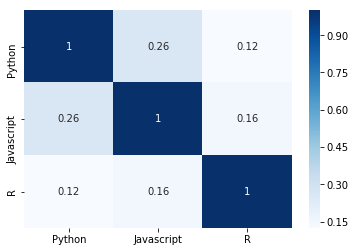

In [51]:
jaccard_indexes = pandas.DataFrame(
    numpy.array([
        [
            jaccard_index(python_keywords, python_keywords),
            jaccard_index(python_keywords, javascript_keywords),
            jaccard_index(python_keywords, r_keywords),
        ],
        [
            jaccard_index(javascript_keywords, python_keywords),
            jaccard_index(javascript_keywords, javascript_keywords),
            jaccard_index(javascript_keywords, r_keywords),
        ],
        [
            jaccard_index(r_keywords, python_keywords),
            jaccard_index(r_keywords, javascript_keywords),
            jaccard_index(r_keywords, r_keywords),
        ],
    ]),
    columns=['Python', 'Javascript', 'R'],
    index=['Python', 'Javascript', 'R'],
)

hm = seaborn.heatmap(
    jaccard_indexes,
    annot=True,
    cmap='Blues',
)

Here, it can be seen that the programming languages share a large percentage of words (e.g "if", "else" ...).